# Milestone 2: Feature Engineering & Baseline Model Development

## Objectives
- 🔧 **Feature Engineering**: Create lag features, rolling windows, and time-based features.
- 📊 **EDA**: Analyze correlations and feature importance.
- 🤖 **Baseline Modeling**: Train initial models (Linear Regression, Random Forest, LSTM).
- 📉 **Evaluation**: Assess model performance using RMSE, MAE, R².

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
# Load Processed Data from Milestone 1
try:
    df = pd.read_csv('../Dataset/cleaned_household_power_consumption.csv', index_col='DateTime', parse_dates=True)
    print("✅ Loaded processed data successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Processed data not found. Please run Milestone 1 notebook first.")

✅ Loaded processed data successfully!
Shape: (34589, 14)


## 1️⃣ Feature Engineering

In [3]:
# Create Temporal Features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['IsWeekend'] = (df.index.dayofweek >= 5).astype(int)

# Create Lag Features (Past 1 hour, 24 hours)
df['lag_1h'] = df['Global_active_power'].shift(1)
df['lag_24h'] = df['Global_active_power'].shift(24)

# Rolling Statistics (Moving Average & Standard Deviation)
df['rolling_mean_24h'] = df['Global_active_power'].rolling(window=24).mean()
df['rolling_std_24h'] = df['Global_active_power'].rolling(window=24).std()

# Drop NaN values created by shifting
df.dropna(inplace=True)
print("✅ Feature Engineering (Temporal, Lags, Rolling) Complete")


✅ Feature Engineering (Temporal, Lags, Rolling) Complete


### 1.2 Device-Level Aggregations (Week 3 Requirement)

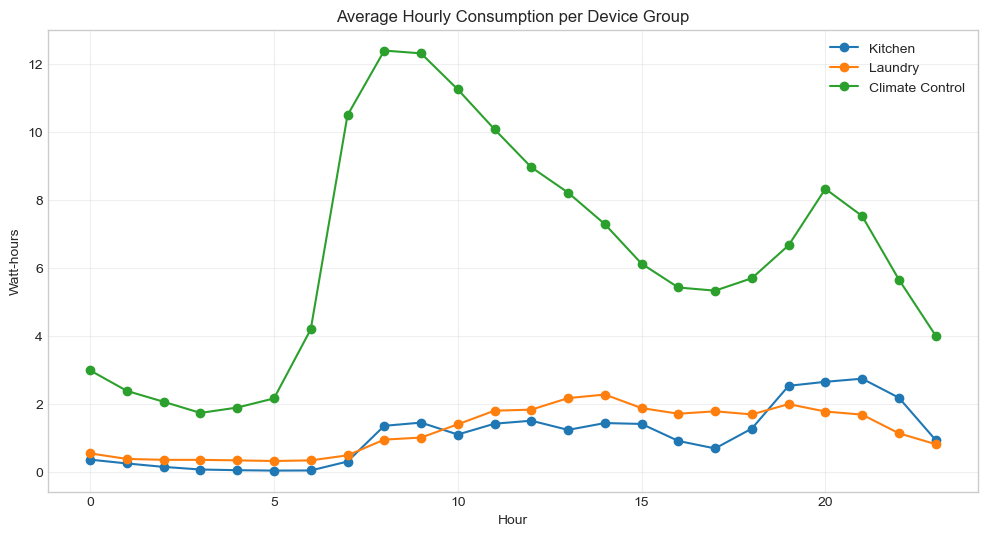

📊 Peak usage for Kitchen (Sub_1): 21 h
📊 Peak usage for Climate Control (Sub_3): 8 h


In [4]:
# Device-Level Aggregations: Average consumption per sub-metering area
device_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
device_hourly_avg = df.groupby('Hour')[device_cols].mean()

plt.figure(figsize=(12, 6))
device_hourly_avg.plot(ax=plt.gca(), marker='o')
plt.title('Average Hourly Consumption per Device Group')
plt.ylabel('Watt-hours')
plt.grid(True, alpha=0.3)
plt.legend(['Kitchen', 'Laundry', 'Climate Control'])
plt.show()

print("📊 Peak usage for Kitchen (Sub_1):", device_hourly_avg['Sub_metering_1'].idxmax(), "h")
print("📊 Peak usage for Climate Control (Sub_3):", device_hourly_avg['Sub_metering_3'].idxmax(), "h")

## 2️⃣ Baseline Modeling

RMSE: 0.5066
MAE: 0.3606
R² Score: 0.5017


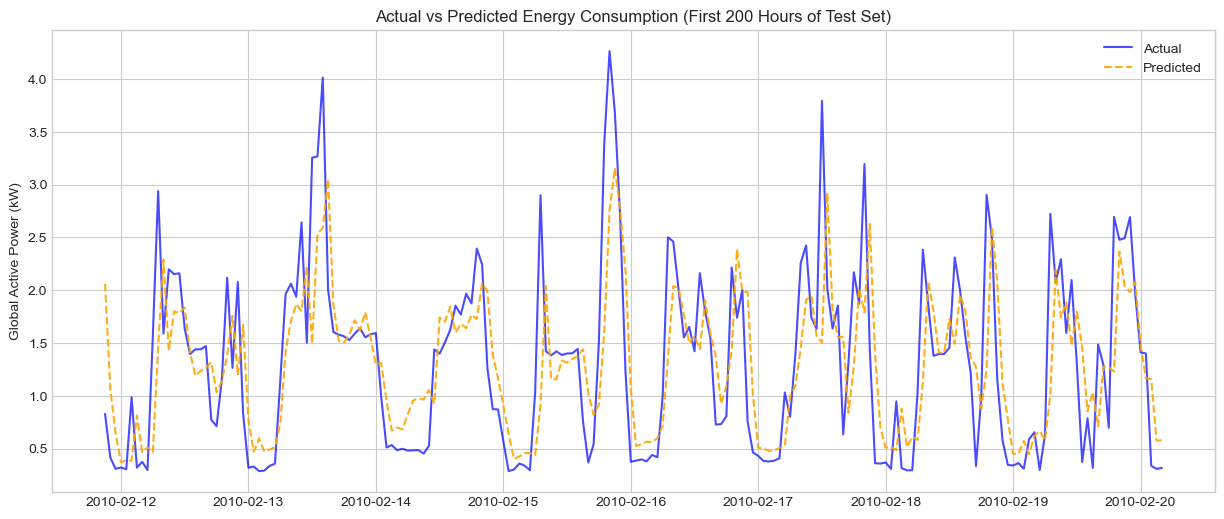

In [5]:
# Linear Regression Baseline
features = ['lag_1h', 'lag_24h', 'rolling_mean_24h', 'rolling_std_24h', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend']
target = 'Global_active_power'

X = df[features]
y = df[target]
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 📉 Visualization: Actual vs Predicted (Week 4 Requirement)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:200], y_test.values[:200], label='Actual', alpha=0.7, color='blue')
plt.plot(y_test.index[:200], y_pred[:200], label='Predicted', alpha=0.9, color='orange', linestyle='--')
plt.title('Actual vs Predicted Energy Consumption (First 200 Hours of Test Set)')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()